In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
# 2. Đọc file dữ liệu và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('VCB_Historical_Data.csv')
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]


In [3]:
!pip install pmdarima

You should consider upgrading via the 'C:\Users\ngomi\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
#3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1) 
y_train = np.array(train_data['Close'])

#Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima 
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

#Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20339.830, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20340.953, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20342.635, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20342.669, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20340.757, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20341.663, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20341.976, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=20333.668, Time=1.56 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=20342.344, Time=0.51 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=20333.898, Time=1.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=20342.783, Time=0.77 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=20337.620, Time=1.87 sec
 ARIMA(3,1,2)(0,0,0)[0]        

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [5]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [6]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted opening prices for the next 30 days
print('Predicted opening prices for the next 30 days:')
print(y_next_30_days)

Predicted opening prices for the next 30 days:
[75917.24490851 75995.3814275  75952.03054372 75864.47868323
 75863.55636786 75941.75365042 75978.04563699 75924.29662696
 75867.33585605 75889.76054566 75951.07214343 75958.74477241
 75907.17672406 75876.90057217 75909.46925095 75951.42298057
 75941.20869549 75898.90868447 75888.89533712 75922.33251974
 75946.48745671 75927.42120401 75897.08700782 75900.44807141
 75929.20753828 75939.23298418 75917.95848007 75899.30875658
 75909.95166619 75931.52288734]


In [7]:
# 7. Tính RMSE, MSE, MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

valid_mse = mean_squared_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred)

valid_rmse = np.sqrt(valid_mse)
test_rmse = np.sqrt(test_mse)

valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)*100
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 16312.530659307913
Testing RMSE: 8520.094570665837
Validation MAE: 15112.114175501882
Testing MAE: 6603.549059819972
Validation MAPE: 16.241637279027614
Testing MAPE: 7.791849092981229


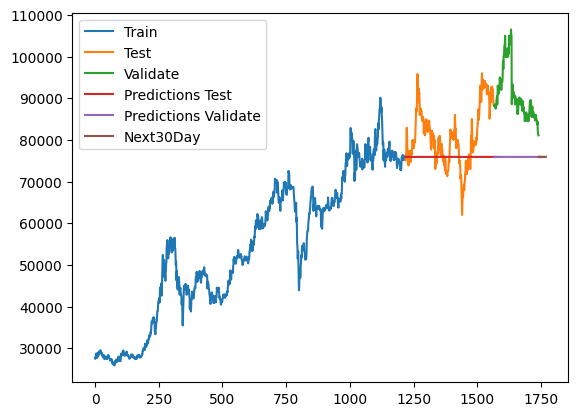

In [8]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions Test', 'Predictions Validate','Next30Day'])
plt.show()

In [9]:
test_data.index

RangeIndex(start=1218, stop=1566, step=1)